## Modeling effect of Beaver Dam/ BDAs on NDVI

Code will build model that places appropriate location for construction of BDAs, and potential resultant increase of NDVI. Factors to include in the model are based on known factors from literature, including:

1. Slope
2. Atmospheric Temperature
3. Runoff
4. Precipitation patterns
5. Top soil coarseness
6. Stream width

The model will be built on most recent complete availability of satellite imagery, which is the average of each of the factors indicated over the period between 2016-2018.

In [1]:
#import needed libraries in

import ee
import numpy as np
import pandas as pd

import geemap.eefolium as geemap
import folium
from folium import plugins

from earthshot import normalize as norm
from earthshot import water_viz as vis

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

Loading BokehJS ...

In [2]:
#Initialize Earth Engine
ee.Initialize()

## Import beaver dam feature collections

In [3]:
#Import beaver dam feature collections from GEE for different states, merging collections that need to be merged 
#together.

#Define functions that map the presence/ absence of beaver dams over the collections, then map over feature collections
def set_present(feature):
    return feature.set('Beaver Dam', 1)

def set_absent(feature):
    return feature.set('Beaver Dam', 0)

CA_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/06_CaliforniaDams_Boxes_yes_BeaverDam')
                    .map(set_present))
CA_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/06_CaliforniaDams_Boxes_no_BeaverDam')
                    .map(set_absent))
CO_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_yes_BeaverDam')
                    .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_allIntersect'))
                    .map(set_present))
CO_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/05_ColoradoDams_Boxes_no_BeaverDam')
                      .map(set_absent))
ID_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_yes_BeaverDam')
                    .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_allIntersect'))
                    .map(set_present))
ID_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/04_IdahoDams_Boxes_no_BeaverDam')
                      .map(set_absent))
WY_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_yes_BeaverDam')
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_allIntersect'))
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_yes_BeaverDam'))
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_allIntersect'))
                        .map(set_present))
WY_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/01_WyomingDams_Boxes_no_BeaverDam')
                      .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/02_WyomingDams_Boxes_yes_BeaverDam'))
                    .map(set_absent))
OR_Dam_Data_Present = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_yes_BeaverDam')
                       .merge(ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_allIntersect'))
                        .map(set_present))
OR_Dam_Data_Absent = (ee.FeatureCollection('users/amgadellaboudy/Beaver_Dams_A/03_OregonDams_Boxes_no_BeaverDam')
                    .map(set_absent))

#Merge present and absent feature collections by state

dam_data_CA = CA_Dam_Data_Present.merge(CA_Dam_Data_Absent)
dam_data_CO = CO_Dam_Data_Present.merge(CO_Dam_Data_Absent)
dam_data_ID = ID_Dam_Data_Present.merge(ID_Dam_Data_Absent)
dam_data_WY = WY_Dam_Data_Present.merge(WY_Dam_Data_Absent)
dam_data_OR = OR_Dam_Data_Present.merge(OR_Dam_Data_Absent)

## Factor import

In [4]:
#Define bounding box for are of interest, the American West

bbox_west = ee.Geometry.BBox(-125, 30, -103, 49)

#Import variables in (Slope, Temperature, Runoff, Net Solar Radiation, Precipitation, Top soil type), averaged over 
#2016-2018 and clipped to bounding box.

slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope').clip(bbox_west)
#slope_global = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope')
#Scale = 90 m

#Import for temperature, runoff, precipitation, and net solar radiation

ERA5_img = (ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('2016-01-01', '2018-12-31')
            .select(['temperature_2m', 'surface_runoff', 'surface_net_solar_radiation', 'total_precipitation'])
            .mean().clip(bbox_west))
#https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY
#scale = 11 km

#Import soil types in from USDA database
soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02").clip(bbox_west)
#https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_TEXTURE-CLASS_USDA-TT_M_v02
#Scale = 250 m

#Expression to add the top three soil properties to each other
top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')})

#Import stream width image in, to be masked to later
water_img = ee.Image("MERIT/Hydro/v1_0_1").select('viswth').clip(bbox_west)
#https://developers.google.com/earth-engine/datasets/catalog/MERIT_Hydro_v1_0_1#bands
#Scale = 90 m


In [5]:
#Function to calculate NDVI

def addNDVI(image):
    ndvi = image.normalizedDifference(['N', 'R']).rename('NDVI')
    return image.addBands(ndvi)

#Importing in satellite imagery for the most recent period as well as the period right before

NDVI_a = (ee.ImageCollection('USDA/NAIP/DOQQ')
        .filterDate('2016-01-01', '2018-12-31')
        .map(addNDVI)
        .select('NDVI')
        .mean()
        .clip(bbox_west))

#Mask to NDVI greater than -0.25, which takes out streams/ rivers/ bodies of water, as well as some excessively
#dry areas

mask = NDVI_a.gte(-0.25)
NDVI = NDVI_a.updateMask(mask)

NDVI_pre_a = (ee.ImageCollection('USDA/NAIP/DOQQ')
        .filterDate('2013-01-01', '2015-12-31')
        .map(addNDVI)
        .select('NDVI')
        .mean()
        .clip(bbox_west)
        .rename('NDVI_pre'))

mask = NDVI_pre_a.gte(-0.25)
NDVI_pre = NDVI_pre_a.updateMask(mask)

In [6]:
#Compile an image via bands for each factor to create a feature collection for model training

training_img = slope_img.addBands(ERA5_img).addBands(top_soils).addBands(NDVI_pre).addBands(NDVI)
print(training_img.bandNames().getInfo())

['slope', 'temperature_2m', 'surface_runoff', 'surface_net_solar_radiation', 'total_precipitation', 'b0', 'NDVI_pre', 'NDVI']


## Factor visualization

In [7]:
from earthshot import water_viz as vis

palette_name = 'BrBG'
palette_len = 10
palette = vis.brewer[palette_name][palette_len][::-1]

min = -0.25
max = 0.75

viz_params_NDVI = {'min': min, 'max': max, 'palette': palette}
viz_params_runoff = {'min': 0, 'max': 0.0005, 'palette': palette}
viz_params_precip = {'min': 0, 'max': 0.005, 'palette': palette}
viz_params_soil = {'min': 5, 'max': 30, 'palette': palette}
viz_params_temp = {'min': 270, 'max': 300, 'palette': palette}


#import branca
#colormap = branca.colormap.LinearColormap(colors = ['#964B00', '#006400'], vmin = 0, vmax = 0.2)
#colormap = colormap.to_step(n= 10)
#colormap.caption = 'NDVI increase potential'

vis.legend(palette=palette, title = 'Legend', minimum = min, maximum = max)

the_map = geemap.Map()
the_map.addLayer(training_img.select('NDVI'), viz_params_NDVI, name = 'NDVI')
the_map.addLayer(training_img.select('NDVI_pre'), viz_params_NDVI, name = 'NDVI_pre')
the_map.addLayer(training_img.select('surface_runoff'), viz_params_runoff, name = 'Runoff')
the_map.addLayer(training_img.select('total_precipitation'), viz_params_precip, name = 'Precip')
the_map.addLayer(training_img.select('b0'), viz_params_soil, name = 'Top Soils')
the_map.addLayer(training_img.select('temperature_2m'), viz_params_temp, name = 'Temperature')

vis.folium_display(the_map)

## Model setup and training

In [8]:
target = 'NDVI' #define target prediction
bands = ['Beaver Dam', 'slope', 'temperature_2m', 'surface_runoff', 'surface_net_solar_radiation', 
         'total_precipitation', 'b0','NDVI_pre'] #define bands that will act as factors in model
not_null = ['slope', 'temperature_2m', 'surface_runoff', 'surface_net_solar_radiation', 'total_precipitation',
            'b0', 'NDVI_pre', 'NDVI', 'Beaver Dam'] #list to filter out any null values for features or prediction

#Using "reduce regions", create feature collection for each state that stores a square for each feature that has
#average values for each of the factors, as well as the target
training_CA = (training_img.reduceRegions(collection = dam_data_CA, reducer = ee.Reducer.mean(), scale = 1, tileScale = 16)).filter(ee.Filter.notNull(not_null))
training_CO = (training_img.reduceRegions(collection = dam_data_CO, reducer = ee.Reducer.mean(), scale = 1, tileScale = 16)).filter(ee.Filter.notNull(not_null))
training_ID = (training_img.reduceRegions(collection = dam_data_ID, reducer = ee.Reducer.mean(), scale = 1, tileScale = 16)).filter(ee.Filter.notNull(not_null))
training_WY = (training_img.reduceRegions(collection = dam_data_WY, reducer = ee.Reducer.mean(), scale = 1, tileScale = 16)).filter(ee.Filter.notNull(not_null))
training_OR = (training_img.reduceRegions(collection = dam_data_OR, reducer = ee.Reducer.mean(), scale = 1, tileScale = 16)).filter(ee.Filter.notNull(not_null))


In [9]:
#Export training data out for ease of processing

training_export = training_CA.merge(training_CO).merge(training_ID).merge(training_WY).merge(training_OR)

xx = ee.batch.Export.table.toAsset(training_export, 'training_coll_export', 'users/amgadellaboudy/training_coll').start()

In [10]:
#Test/ validation split, fit classifier for training data

training = ee.FeatureCollection('users/amgadellaboudy/training_coll')

random = training.randomColumn(columnName = 'randomized', seed = 101)
split = 0.8

training_split = random.filter(ee.Filter.lt('randomized', split))
validation_split = random.filter(ee.Filter.gte('randomized', split))

model = (ee.Classifier.smileGradientTreeBoost(numberOfTrees = 2500, shrinkage = 0.05, samplingRate = 0.4, 
                                             maxNodes = 4, loss = 'LeastSquares').setOutputMode('REGRESSION')
        .train(features= training_split, classProperty= target, inputProperties = bands))

In [11]:
#Output predicted NDVI on validated data based on model

trained = training_split.classify(model)
validated = validation_split.classify(model)

In [12]:
#Training accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

selectors = ee.List(['NDVI', 'classification', 'Beaver Dam'])

list_1 = ee.List(trained.reduceColumns(reducer = ee.Reducer.toList().repeat(selectors.size()), selectors = selectors).get('list'))
list_2 = ee.List(validated.reduceColumns(reducer = ee.Reducer.toList().repeat(selectors.size()), selectors = selectors).get('list'))
                                        
y_test_t = ee.List(list_1.get(0)).getInfo()
predictions_t = ee.List(list_1.get(1)).getInfo()
color_t = ee.List(list_1.get(2)).getInfo()

y_test_v = ee.List(list_2.get(0)).getInfo()
predictions_v = ee.List(list_2.get(1)).getInfo()
color_v = ee.List(list_2.get(2)).getInfo()


RMSE_trained = np.sqrt(mean_squared_error(y_test_t, predictions_t))
RMSE_validated = np.sqrt(mean_squared_error(y_test_v, predictions_v))

print('RMSE (training):', RMSE_trained)
print('RMSE (validation):', RMSE_validated)

RMSE (training): 0.04155273824170024
RMSE (validation): 0.04711769064597335


In [13]:
#Print percentage error for training vs. validation data

percentage_t = (100*RMSE_trained)/np.mean(y_test_t)
percentage_v = (100*RMSE_validated)/np.mean(y_test_v)
print('Error Percentage (training):', percentage_t)
print('Error Percentage (validation):', percentage_v)

Error Percentage (training): 27.854443784753038
Error Percentage (validation): 31.946904921347038


In [14]:
#Explained variance of trained and validated data

exp_var_t = explained_variance_score(y_test_t, predictions_t)
exp_var_v = explained_variance_score(y_test_v, predictions_v)

print('Explained variance (training):', exp_var_t) 
print('Explained variance (validation):', exp_var_v) 

Explained variance (training): 0.8982639615152197
Explained variance (validation): 0.869740838550213


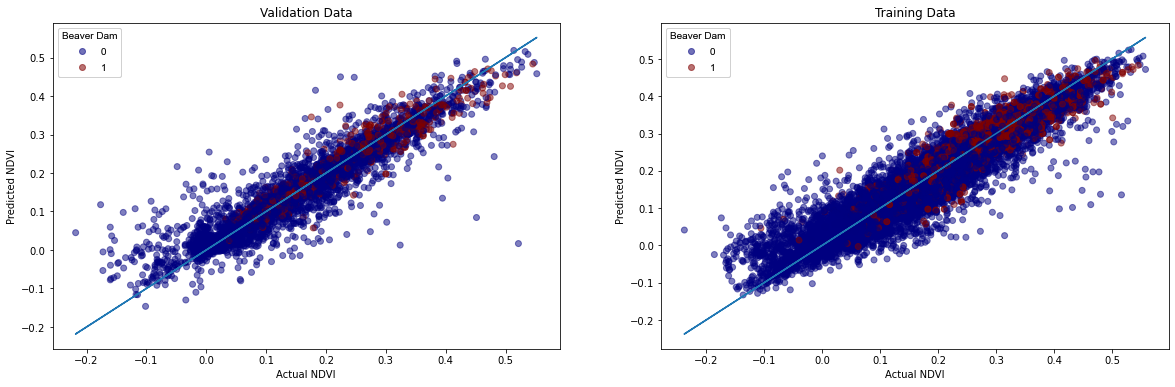

In [15]:
#Plot validation/ training data vs. predictions

fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (20,6))

font = {'family' : 'Arial',
        'size'   : 10}

plt.rc('font', **font)

scatter = ax[0].scatter(y_test_v, predictions_v, c = color_v, cmap = 'jet', alpha = 0.5)
plot = ax[0].plot(y_test_v, y_test_v)
legend1 = ax[0].legend(*scatter.legend_elements(), loc="upper left", title="Beaver Dam")
ax[0].add_artist(legend1)
ax[0].set(title = 'Validation Data', xlabel = 'Actual NDVI', ylabel = 'Predicted NDVI')

plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')

scatter_t = ax[1].scatter(y_test_t, predictions_t, c = color_t, cmap = 'jet', alpha = 0.5)
plot_t = ax[1].plot(y_test_t, y_test_t)
legend2 = ax[1].legend(*scatter.legend_elements(), loc="upper left", title="Beaver Dam")
ax[1].add_artist(legend2)
ax[1].set(title = 'Training Data', xlabel = 'Actual NDVI', ylabel = 'Predicted NDVI')



plt.show()


In [16]:
#Prep data to visualize effect of presence of beaver dams

selectors_a = ee.List(['NDVI', 'Beaver Dam'])

beaver_data = pd.DataFrame(trained.reduceColumns(reducer  = ee.Reducer.toList().repeat(selectors_a.size()), selectors = selectors_a)
            .getInfo()['list']).transpose().rename(columns = {0: 'NDVI', 1: 'Beaver Dam'})

selectors_b = ee.List(['classification', 'Beaver Dam'])

beaver_data_model = pd.DataFrame(trained.reduceColumns(reducer  = ee.Reducer.toList().repeat(selectors_b.size()), selectors = selectors_b)
            .getInfo()['list']).transpose().rename(columns = {0: 'NDVI', 1: 'Beaver Dam'})

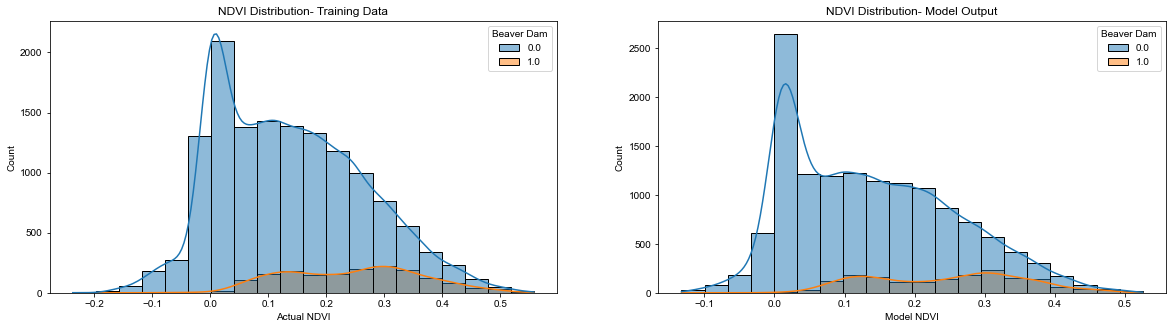

In [17]:
#Showing distribution of NDVI for actual values and model values, separated by absence/ presence of beaver dam
import seaborn as sns

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plot = sns.histplot(data = beaver_data, x = 'NDVI', bins = 20, hue = 'Beaver Dam', stat = 'count', kde = True, ax = ax[0])
ax[0].set(title = 'NDVI Distribution- Training Data', xlabel = 'Actual NDVI')

plot_2 = sns.histplot(data = beaver_data_model, x = 'NDVI', bins = 20, hue = 'Beaver Dam', stat = 'count', kde = True, ax = ax[1])
ax[1].set(title = 'NDVI Distribution- Model Output', xlabel = 'Model NDVI')

plt.show()

In [18]:
print('NDVI mean (absent):', np.mean(beaver_data.loc[beaver_data['Beaver Dam'] == 0, 'NDVI']))
print('NDVI mean (present):', np.mean(beaver_data.loc[beaver_data['Beaver Dam'] == 1, 'NDVI']))

NDVI mean (absent): 0.13748996382489645
NDVI mean (present): 0.24544228389086106


In [19]:
#Create an image that is trained via model to predict NDVI if beaver dams were built everywhere

trained_image = training_img.addBands(1).rename(not_null).clip(bbox_west).classify(model)

In [20]:
#Visualize NDVI change if beaver dams were built in every possible location

palette_name = 'BrBG'
palette_len = 10
palette = vis.brewer[palette_name][palette_len][::-1]

min = 0
max = 0.25

viz_params_change = {'min': min, 'max': max, 'palette': palette}

#Calculating NDVI change and mask to areas where improvement is shown
mask = water_img.gte(0.5)
subtraction = trained_image.subtract(NDVI)
mask_2 = subtraction.gte(0)
NDVI_change = subtraction.updateMask(mask).updateMask(mask_2)

vis.legend(palette=palette, title = 'NDVI change potential', minimum = min, maximum = max)

the_map = geemap.Map()
the_map.addLayer(NDVI_change, viz_params_change, name = 'NDVI Change')

vis.folium_display(the_map)